# OMICS data project demo
### August George, 2023

#### 0. Problem definition:

Build a predictive model for type 2 diabetes from gene expression levels in muscle biopsies. 

Considerations: human subjects --> data has been anonymized, data is freely available and open-source, model results are preliminary and may not be accurate predictors. 

#### 1. Data collection:

We use the GSE9006 dataset "Gene expression in PBMCs from children with diabetes". 

Design: "We obtained blood samples from 24 healthy volunteers, 43 newly diagnosed T1D patients and 12 newly diagnosed T2D patients. All study participants were between the ages of 2 and 18 years. We collected samples one and four months after diagnosis from the last 20 of the T1D patients. For each time point one sample did not pass quality control and was dropped from the analysis. Patients with T2D were distinguished from T1D on the basis of age, body habitus,
presence (11/12 patients) of acanthosis nigricans, family history of type 2 diabetes (11/12 patients), and absence of autoantibodies to insulin, IA-2, and GAD65. We allowed low titers of insulin antibodies in T2D patients (< 4 U/mL), which have been previously reported. All but two
of the T1D patients with positive anti-insulin antibodies were also positive for at least one additional autoantibody. "

See ref: Kaizer EC, Glaser CL, Chaussabel D, Banchereau J et al. Gene expression in peripheral blood mononuclear cells from children with diabetes. J Clin Endocrinol Metab 2007 Sep;92(9):3705-11. PMID: 17595242

##### data notes:
* 2 complementary micro-array platforms used to collect data have some overlaping as well as independant gene coverage
* use series matrix files and accompanying probe to gene mapping. 
* remove NaN samples / probes
* use average expression values when possible 
* some samples are the same individual at a different time points, consider these independant samples for now (NOT ACCURATE, FIX THIS!)

want data output to have features = gene symbol, and samples = sample title, with labels for No Diabetes, Diabetes 1, and Diabetes2.

#### download data

In [23]:
import os
import urllib.request
import gzip
import pandas as pd

urls = [
    "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE9nnn/GSE9006/matrix/GSE9006-GPL96_series_matrix.txt.gz",
    "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE9nnn/GSE9006/matrix/GSE9006-GPL97_series_matrix.txt.gz"
]

filenames = [
    "GSE9006-GPL96_series_matrix.txt.gz",
    "GSE9006-GPL97_series_matrix.txt.gz"
]

mapping_files = [
    "GPL96-57554.txt",
    "GPL97-17394.txt"
]

def download_and_extract_files(urls, filenames, directory):
    for url, filename in zip(urls, filenames):
        file_path = os.path.join(directory, filename)
        urllib.request.urlretrieve(url, file_path)
        print(f"File '{filename}' downloaded and saved to '{file_path}'.")

        extracted_file_path = os.path.join(directory, filename[:-3])
        with gzip.open(file_path, 'rb') as f_in:
            with open(extracted_file_path, 'wb') as f_out:
                f_out.write(f_in.read())
        print(f"File '{filename}' extracted and saved to '{extracted_file_path}'.")

base_directory = os.getcwd()  # Get the current working directory
new_directory = "data"
directory_path = os.path.join(base_directory, new_directory)

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists. Skipping creation.")

download_and_extract_files(urls, filenames, directory_path)




Directory '/Users/georgeau/Desktop/GitHub/omics_demo/data' already exists. Skipping creation.
File 'GSE9006-GPL96_series_matrix.txt.gz' downloaded and saved to '/Users/georgeau/Desktop/GitHub/omics_demo/data/GSE9006-GPL96_series_matrix.txt.gz'.
File 'GSE9006-GPL96_series_matrix.txt.gz' extracted and saved to '/Users/georgeau/Desktop/GitHub/omics_demo/data/GSE9006-GPL96_series_matrix.txt'.
File 'GSE9006-GPL97_series_matrix.txt.gz' downloaded and saved to '/Users/georgeau/Desktop/GitHub/omics_demo/data/GSE9006-GPL97_series_matrix.txt.gz'.
File 'GSE9006-GPL97_series_matrix.txt.gz' extracted and saved to '/Users/georgeau/Desktop/GitHub/omics_demo/data/GSE9006-GPL97_series_matrix.txt'.


##### Parse the data into a .csv file

In [101]:
import csv

def load_and_clean_matrix_file(matrix_file_path):
    # Open the file and read the lines
    with open(matrix_file_path, 'r') as f:
        lines = f.readlines()

    # Get the line containing sample titles
    sample_title_line = lines[37]
    # Split the line into titles and remove the descriptor
    sample_titles = sample_title_line.split('\t')[1:]
    sample_titles = [title.strip('"').strip() for title in sample_titles]
    sample_titles[-1] = sample_titles[-1].rstrip('\n')

    # Load series matrix data
    matrix_data = pd.read_csv(matrix_file_path, sep="\t", comment="!", index_col=0)

    # Update the column names
    matrix_data.columns = sample_titles

    print(f"Loaded matrix data from {matrix_file_path} with shape {matrix_data.shape}")

    # Remove probes with "AFFX" in their names
    matrix_data = matrix_data[~matrix_data.index.str.contains("AFFX")]
    print(f"After removing AFFX probes, matrix data shape is {matrix_data.shape}")
    return matrix_data


def remove_nan_and_handle_duplicates(matrix_data):
    # Remove NAN rows/columns
    matrix_data.dropna(inplace=True, axis=1)
    matrix_data.dropna(inplace=True, axis=0)
    print(f"After removing NaNs, matrix data shape is {matrix_data.shape}")
    
    # Handle duplicate columns by averaging
    matrix_data = matrix_data.groupby(by=matrix_data.columns, axis=1).mean()
    print(f"After handling duplicate columns, matrix data shape is {matrix_data.shape}")
    
    # Handle duplicate rows by averaging
    matrix_data = matrix_data.groupby(by=matrix_data.index).mean()
    print(f"After handling duplicate rows, matrix data shape is {matrix_data.shape}")
    return matrix_data


def get_index_mapping_dicts(mapping_file_path):
    # Load mapping data
    mapping_data = pd.read_csv(mapping_file_path, sep="\t", comment="#")
    
    # Create dictionaries for mapping
    probe_to_gene_dict = dict(zip(mapping_data['ID'], mapping_data['Gene Symbol']))
    gene_to_title_dict = dict(zip(mapping_data['Gene Symbol'], mapping_data['Gene Title']))
    return probe_to_gene_dict, gene_to_title_dict


def get_labels_dict(series_matrix_file_path):
    # Open the file and read the lines
    with open(series_matrix_file_path, 'r') as f:
        lines = f.readlines()
    
    #print(lines[50])
    # The line containing labels is the 51st line (0-indexed)
    labels_line = lines[50]
    
    # Split the line into labels and remove the descriptor
    labels = labels_line.split('\t')[1:]
    labels = [label.replace('"Illness: ', '').strip('"') for label in labels]
    labels[-1] = labels[-1].rstrip('"\n')

    # Get the line containing sample titles
    sample_title_line = lines[37]
    # Split the line into titles and remove the descriptor
    sample_titles = sample_title_line.split('\t')[1:]
    sample_titles = [title.strip('"').strip() for title in sample_titles]
    sample_titles[-1] = sample_titles[-1].rstrip('\n')
    
    # Map labels to numbers
    label_to_number = {'Healthy': 0, 'Type 1 Diabetes': 1, 'Type 2 Diabetes': 2}
    labels = [label_to_number[label] for label in labels]
    
    # Create a dictionary mapping sample IDs to labels
    sample_id_to_label_dict = dict(zip(sample_titles, labels)) 
    print(f"Sample ID to Label Dict: {sample_id_to_label_dict}")

    sorted_dict = dict(sorted(sample_id_to_label_dict.items()))

    new_dict = {}
    counter = 1

    for key, value in sorted_dict.items():
        if '1MO' in key:
            new_key = f'x{counter}_1'
            counter += 1
        elif '4MO' in key:
            new_key = f'x{counter}_4'
            counter += 1
        else:
            new_key = f'x{counter}'
            counter += 1
        new_dict[new_key] = value
    return sample_id_to_label_dict

# Load, clean the data
all_data = []
first_labels_dict = None
for i, (matrix_file, mapping_file) in enumerate(zip(filenames, mapping_files)):
    matrix_file_path = os.path.join(directory_path, matrix_file[:-3])  # removing the '.gz' from filename
    mapping_file_path = os.path.join(directory_path, mapping_file)

    # Get probe (index) mapping dictionaries
    probe_to_gene_dict, gene_to_title_dict = get_index_mapping_dicts(mapping_file_path)

    # Get labels dictionary only for the first file
    if i == 0:
        first_labels_dict = get_labels_dict(matrix_file_path)
    sample_id_to_label_dict = first_labels_dict
   
    # Load and clean matrix data
    matrix_data = load_and_clean_matrix_file(matrix_file_path)
    matrix_data = remove_nan_and_handle_duplicates(matrix_data)

    # Map probe IDs to Gene IDs and handle duplicate rows
    matrix_data.index = matrix_data.index.map(probe_to_gene_dict)
    matrix_data = matrix_data.groupby(by=matrix_data.index).mean()

    # Create the new row from the values in sample_id_to_label_dict
    new_row = pd.DataFrame([list(sample_id_to_label_dict.values())], columns=matrix_data.columns, index=['OUTPUT_LABELS'])

    # Append the new row to the matrix_data DataFrame
    matrix_data_with_labels = pd.concat([matrix_data, new_row])
    print(f"Output Labels Row: {matrix_data_with_labels.loc['OUTPUT_LABELS']}")
    
    # Sort the column names
    sorted_columns = matrix_data_with_labels.columns.sort_values()

    # Define the renaming function
    def rename_column(column_name):
        new_name = f'x{sorted_columns.get_loc(column_name) + 1}'
        if '1MO' in column_name:
            new_name += '_1'
        elif '4MO' in column_name:
            new_name += '_4'
        return new_name

    # Rename the columns
    matrix_data_with_labels.columns = [rename_column(column) for column in sorted_columns]
    
    # add data to data list
    all_data.append(matrix_data_with_labels)


# Concatenate all the DataFrames in the list, excluding the 'OUTPUT_LABELS' row
combined_data = pd.concat([data.drop(index='OUTPUT_LABELS') for data in all_data], axis=0, join='outer')

# Group by index and calculate the mean to average the rows with the same indices
combined_data = combined_data.groupby(combined_data.index).mean()

# Now, handle 'OUTPUT_LABELS' separately
combined_labels = pd.concat([data.loc['OUTPUT_LABELS'] for data in all_data], axis=1)

# As these are categorical, we should use mode (most frequent) instead of mean
combined_labels = combined_labels.mode(axis=1)[0]  # Select the first mode in case of multiple

# Create a DataFrame with the combined labels
combined_labels_df = pd.DataFrame([combined_labels], index=['OUTPUT_LABELS'])

# Concatenate the combined data with the combined labels DataFrame
combined_data = pd.concat([combined_data, combined_labels_df])

combined_data.to_csv('combined_data.csv', index=True)

Sample ID to Label Dict: {'PBMCs-Healthy-H122_Healthy': 0, 'PBMCs-Healthy-H124_Healthy': 0, 'PBMCs-Healthy-H125_Healthy': 0, 'PBMCs-Healthy-H126_Healthy': 0, 'PBMCs-Healthy-H133_Healthy': 0, 'PBMCs-Healthy-H148_Healthy': 0, 'PBMCs-Healthy-H149_Healthy': 0, 'PBMCs-Healthy-H150_Healthy': 0, 'PBMCs-Healthy-H152_Healthy': 0, 'PBMCs-Healthy-H166_Healthy': 0, 'PBMCs-Healthy-H171_Healthy': 0, 'PBMCs-Healthy-H176_Healthy': 0, 'PBMCs-Healthy-H178_Healthy': 0, 'PBMCs-Healthy-H28_Healthy': 0, 'PBMCs-Healthy-H37_Healthy': 0, 'PBMCs-Healthy-H42_Healthy': 0, 'PBMCs-Healthy-H48_Healthy': 0, 'PBMCs-Healthy-H98_Healthy': 0, 'PBMCs-Healthy-HIDDM2_Healthy': 0, 'PBMCs-Healthy-HIDDM4_Healthy': 0, 'PBMCs-Type 1 Diabetes-IDDM1_T1D_New': 1, 'PBMCs-Type 1 Diabetes-IDDM11_T1D_New': 1, 'PBMCs-Type 1 Diabetes-IDDM14_T1D_New': 1, 'PBMCs-Type 1 Diabetes-IDDM15_T1D_New': 1, 'PBMCs-Type 1 Diabetes-IDDM16_T1D_New': 1, 'PBMCs-Type 1 Diabetes-IDDM17_T1D_New': 1, 'PBMCs-Type 1 Diabetes-IDDM18_T1D_New': 1, 'PBMCs-Type 1 D


#### 2. Data pre-processing
Split to train and test (80/20) and normalize the data to between 0 and 1



In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv('combined_data.csv', index_col=0)

def normalize_row(row):
    return (row - row.min()) / (row.max() - row.min())

# Normalize all rows except for the 'OUTPUT_LABELS' row
for row in df.index:
    if row != 'OUTPUT_LABELS':
        df.loc[row] = normalize_row(df.loc[row])

# Transpose back to original format and save to a new CSV file
df.to_csv('normalized_data.csv')


# Load your data
df = pd.read_csv('combined_data.csv', index_col=0).T
X = df.drop('OUTPUT_LABELS', axis=1)
y = df['OUTPUT_LABELS']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# Save as csv
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

# Save labels as csv
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

#### 3. Exploratory Data Analysis

Examine the data statistics and plot data (if tractable). Examine correlated features and most important features using Random Forest Classifier.
Also examine dimensionality reduction and featurization using UMAP.  

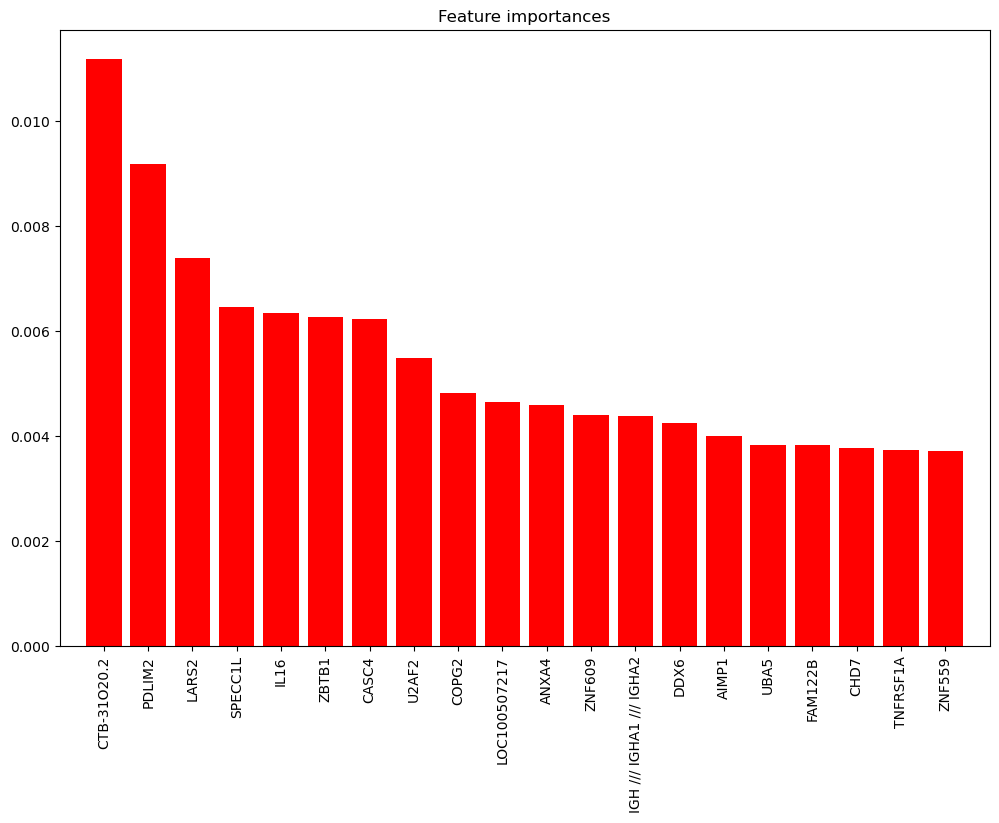

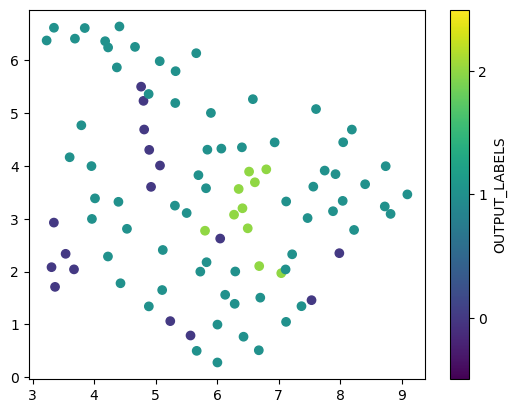

In [20]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from umap import UMAP



# Scaled data (in previous steps)
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled.describe()
X_test_scaled.describe()

# Fit the RandomForestClassifier to our scaled training data
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_scaled, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Sort them in descending order and get the top 20 features
indices = np.argsort(importances)[::-1]
top_features = X_train_scaled.columns[indices[:20]]

plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(20), importances[indices[:20]], color="r", align="center")
plt.xticks(range(20), top_features, rotation='vertical')
plt.xlim([-1, 20])
plt.show()

# Now, we have the top 20 features. We can select these features for our training and test data.
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

# Create UMAP transformer with 2 components for visualization
umap = UMAP(n_neighbors=5, min_dist=0.3, n_components=2)

# Fit on the training data and transform both the training and test data
X_train_umap = umap.fit_transform(X_train_scaled)
X_test_umap = umap.fit_transform(X_test_scaled)

# Now plot the data. Since you have 3 labels, let's color the points based on the labels
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis')
plt.colorbar(label='OUTPUT_LABELS', ticks=range(3))
plt.clim(-0.5, 2.5)
plt.show()




#### 4. Modeling

Try various ML models and compare performance, optimizing hyperparameters using GridSearch. 
Since data is imbalanced, perform over sampling w/ SMOTE. 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE



def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=X_train_selected.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # changed this line because you have 3 classes
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # changed loss to 'categorical_crossentropy' because you have 3 classes
    return model

# Define the hyperparameters and models
model_params = {
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [0.1, 1, 10]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [50, 100, 200],
            'max_depth' : [None, 10, 20],
        }
    },
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
        }
    },
    'xgboost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
        }
    },
    'neural_network': {
        'model': KerasClassifier(build_fn=create_model, verbose=0),
        'params': {
            'batch_size': [10, 20, 40],
            'epochs': [10, 50, 100],
        }
    },
}


# Create a SMOTE object
sm = SMOTE(random_state=42)

# Resample the dataset
X_res, y_res = sm.fit_resample(X_train_selected, y_train)


# Perform grid search
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_res, y_res)
    print("Best parameters for ", model_name, " : ", clf.best_params_)
    print("Best score for ", model_name, " : ", clf.best_score_)
    
    # Evaluate the model on test data
    y_pred = clf.predict(X_test_selected)
    print(classification_report(y_test, y_pred))


/opt/miniconda3/envs/py311_omics/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_57018/3025455968.py:57: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  'model': KerasClassifier(build_fn=create_model, verbose=0),


Best parameters for  logistic_regression  :  {'C': 10}
Best score for  logistic_regression  :  0.9208536585365854
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.75      0.86      0.80        14
         2.0       1.00      1.00      1.00         2

    accuracy                           0.75        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.74      0.75      0.74        24

Best parameters for  random_forest  :  {'max_depth': 10, 'n_estimators': 50}
Best score for  random_forest  :  0.9553658536585365
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.75      0.86      0.80        14
         2.0       1.00      1.00      1.00         2

    accuracy                           0.75        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.74      0.75      0.74      

/opt/miniconda3/envs/py311_omics/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/miniconda3/envs/py311_omics/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/miniconda3/envs/py311_omics/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/miniconda3/envs/py311_omics/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/miniconda3/envs/py311_omics/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_

Best parameters for  xgboost  :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best score for  xgboost  :  0.9504878048780487
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.75      0.86      0.80        14
         2.0       1.00      1.00      1.00         2

    accuracy                           0.75        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.74      0.75      0.74        24

Best parameters for  neural_network  :  {'batch_size': 10, 'epochs': 100}
Best score for  neural_network  :  0.930975615978241
1/1 [==============================] - 0s 43ms/step
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.75      0.86      0.80        14
         2.0       1.00      1.00      1.00         2

    accuracy                           0.75        24
   macro avg       0.81      

##### 5. Analysis

Highest performing methods got a test accuracy of 75%. 

In fact most of the methods got 75% which means either there is an issue in the implementation, or some limit that all the models are reaching. 

Some suggestions to improve the performance: 
* collect more data (there are only ~100 samples)
* do more feature selection and engineering - I tried UMAP and correlation rank, but maybe other methods like t-SNE or kernal PCA would be better
* try other ML models, or ensembles
* try fine-tuning the ML models more